In [1]:
import sys

import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
from sunpy.io.special import read_genx
from sunpy.util import MetaDict
from astropy.visualization import quantity_support

sys.path.append('../scripts/')
from response import SpectrogramChannel

In [2]:
inst_file = '/Users/willbarnes/Google Drive/CubIXSS/MOXSI/MOXSI_effarea.genx'

In [3]:
chan_order1 = SpectrogramChannel(1, inst_file)

In [4]:
chan_order1._data

MetaDict([('channel', 'MOXSI_S1'),
          ('pix_size', 5.599999904632568),
          ('wave',
           array([ 1.   ,  1.055,  1.11 , ..., 59.85 , 59.905, 59.96 ], dtype=float32)),
          ('effarea',
           array([5.4786266e-08, 7.2209275e-08, 1.0308333e-07, ..., 1.2354516e-07,
                  1.2282830e-07, 1.2211430e-07], dtype=float32)),
          ('geo_area', 1.5205308045551647e-05),
          ('filter',
           array([0.99965   , 0.99958473, 0.99951947, ..., 0.20521599, 0.20453744,
                  0.20386156], dtype=float32)),
          ('filter_desc',
           '100 nm of Al based on conversation with Amir 11/11/20'),
          ('grating',
           array([0.03210442, 0.03424337, 0.04105496, ..., 0.03959308, 0.03949394,
                  0.03939453], dtype=float32)),
          ('grating_desc',
           'first order transmission of grating * polyimide, 11/11/20'),
          ('det',
           array([0.11227   , 0.13873997, 0.16521001, ..., 1.        , 1.    

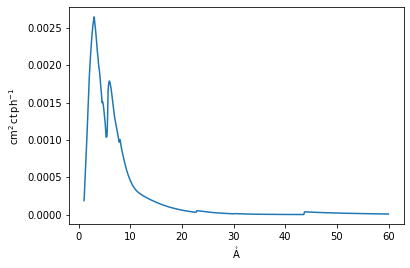

In [7]:
with quantity_support():
    plt.plot(chan_order1.wavelength,chan_order1.wavelength_response)

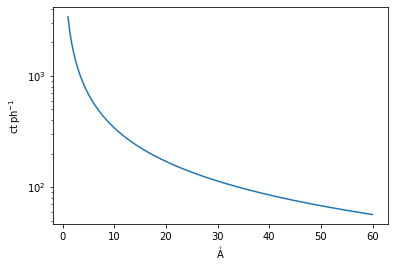

In [9]:
with quantity_support():
    plt.plot(chan_order1.wavelength, chan_order1.gain)
    plt.yscale('log')

## Sandbox

In [49]:
genx_file = '/Users/willbarnes/Google Drive/CubIXSS/MOXSI/MOXSI_effarea.genx'
moxsi_struct = read_genx(genx_file)

In [12]:
for c in moxsi_struct['SAVEGEN0']:
    print(c['CHANNEL'])

MOXSI_S0
MOXSI_S1
MOXSI_S3
MOXSI_S5
Be_thin
Be_med
Be_thick
Al_poly
Al_med
C_poly
Ti_poly


In [40]:
for i in moxsi_struct['SAVEGEN0']:
    print(i['CHANNEL'])

MOXSI_S0
MOXSI_S1
MOXSI_S3
MOXSI_S5
Be_thin
Be_med
Be_thick
Al_poly
Al_med
C_poly
Ti_poly


In [32]:
moxsi_struct['SAVEGEN0'][4]

OrderedDict([('CHANNEL', 'Be_thin'),
             ('PIX_SIZE', 5.599999904632568),
             ('WAVE',
              array([ 1.   ,  1.055,  1.11 , ..., 59.85 , 59.905, 59.96 ], dtype=float32)),
             ('EFFAREA',
              array([1.7061097e-06, 2.1082133e-06, 2.5102615e-06, ..., 9.6050013e-39,
                     7.6424226e-39, 6.5886531e-39], dtype=float32)),
             ('GEO_AREA', 1.5205308045551647e-05),
             ('FILTER',
              array([9.9941999e-01, 9.9935019e-01, 9.9928045e-01, ..., 6.3168743e-34,
                     5.0261539e-34, 4.3331275e-34], dtype=float32)),
             ('FILTER_DESC', '9 micron Be filter / XRT thin Be - no support'),
             ('GRATING', array([1., 1., 1., ..., 1., 1., 1.], dtype=float32)),
             ('GRATING_DESC', 'no grating'),
             ('DET',
              array([0.11227   , 0.13873997, 0.16521001, ..., 1.        , 1.        ,
                     1.        ], dtype=float32)),
             ('DET_DESC', 'Assum

We have two classes of "channel":
- filtergram:
    - Be thin
    - Be med
    - Be thick
    - Al poly
- spectrograph:
    - order = 0
    - order = 1 (-1)
    - order = 3 (-3)
    - order = 5 (-5)

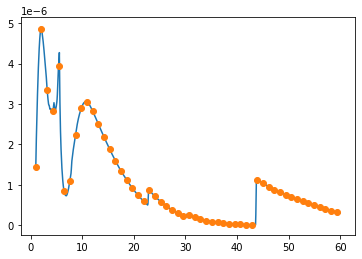

In [29]:
plt.plot(moxsi_struct['SAVEGEN0'][0]['WAVE'],
         moxsi_struct['SAVEGEN0'][0]['EFFAREA'])
s0 = moxsi_struct['SAVEGEN0'][0]
ea = s0['GEO_AREA'] * s0['FILTER'] * s0['GRATING'] * s0['DET']
plt.plot(s0['WAVE'], ea, marker='o', ls=' ', markevery=20)

In [82]:
class Channel:
    
    def __init__(self, name, instrument_file):
        # Switch this to accept a filter type or an order and then construct name
        # based on that.
        self._name = name
        self._instrument_data = self._get_instrument_data(instrument_file)
        
    def _get_instrument_data(self, instrument_file):
        return read_genx(instrument_file)
        
    @property
    def _data(self):
        index_mapping = {}
        for i,c in enumerate(self._instrument_data['SAVEGEN0']):
            index_mapping[c['CHANNEL']] = i
        return MetaDict(self._instrument_data['SAVEGEN0'][index_mapping[self._name]])
        
    @property
    def name(self):
        return self._name
        
    @property
    @u.quantity_input
    def wavelength(self) -> u.angstrom:
        return u.Quantity(self._data['wave'], 'angstrom')
        
    @property
    @u.quantity_input
    def geometrical_collecting_area(self) -> u.cm**2:
        return u.Quantity(self._data['geo_area'], 'cm^2')
        
    @property
    @u.quantity_input
    def filter_transmission(self) -> u.dimensionless_unscaled:
        return u.Quantity(self._data['filter'])
        
    @property
    @u.quantity_input
    def grating_efficiency(self) -> u.dimensionless_unscaled:
        # NOTE: this is just 1 for the filtergrams
        return u.Quantity(self._data['grating'])
        
    @property
    @u.quantity_input
    def detector_efficiency(self) -> u.dimensionless_unscaled:
        return u.Quantity(self._data['det'])
    
    @property
    @u.quantity_input
    def effective_area(self) -> u.cm**2:
        return (self.geometrical_collecting_area * 
                self.filter_transmission *
                self.grating_efficiency *
                self.detector_efficiency)
    
    @property
    @u.quantity_input
    def plate_scale(self) -> u.steradian / u.pixel:
        return u.Quantity(self._data['sr_per_pix'], 'steradian / pixel')
    
    @property
    @u.quantity_input
    def gain(self) -> u.ct / u.photon:
        return u.Quantity(self._data['gain'], 'ct / photon')
    

class SpectrogramChannel(Channel):
    
    def __init__(self, order, instrument_file):
        name = f'MOXSI_S{int(np.fabs(order))}'
        super().__init__(name, instrument_file)

In [73]:
foo = Channel('Be_thin', genx_file)

In [74]:
foo_spec = SpectrogramChannel(0, genx_file)

In [110]:
foo.wavelength.to('keV', equivalencies=u.spectral())

<Quantity [12.398419  , 11.752057  , 11.169748  , ...,  0.20715824,
            0.20696804,  0.20677818] keV>

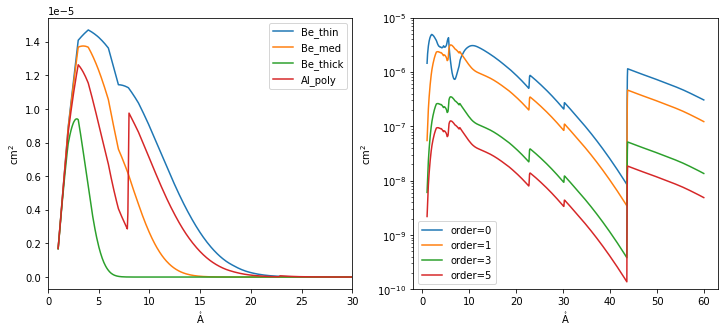

In [111]:
with quantity_support():
    fig = plt.figure(figsize=(12,5))
    ax = fig.add_subplot(121)
    for k in ['Be_thin',
              'Be_med',
              'Be_thick',
              'Al_poly',]:
        foo = Channel(k, genx_file)
        l = ax.plot(foo.wavelength,#.to('keV', equivalencies=u.spectral()),
                    foo.effective_area,
                    label=foo.name)
        #ax.plot(foo.wavelength,foo._data['effarea'], color=l[0].get_color(), marker='.', ls=' ', markevery=20)
    plt.legend()
    plt.xlim(0,30)
    plt.subplot(122)
    for o in [0, 1, 3, 5]:
        foo = SpectrogramChannel(o, genx_file)
        l = plt.plot(foo.wavelength,#.to('keV', equivalencies=u.spectral()),
                     foo.effective_area,
                     label=f'order={o}')
        #plt.plot(foo.wavelength,foo._data['effarea'], color=l[0].get_color(), marker='.', ls=' ', markevery=20)
    plt.legend()
    plt.yscale('log')
    plt.ylim(1e-10,1e-5)